# Part 1 - LDA
the specified parameters of lda: **$C_{12} = C_{21} = 1$ **

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [2]:
# step 1: data setting

iris_data = np.loadtxt('../dataset/iris.txt')

# select class 2 and 3
iris_data = iris_data[50:]

def set_positive_and_negative_data(data, selected_features, split_index=50):
    positive_data = data[:split_index, selected_features]
    positive_data = np.expand_dims(positive_data, axis=2)
    
    negative_data = iris_data[split_index:, selected_features]
    negative_data = np.expand_dims(negative_data, axis=2)

    return positive_data, negative_data

positive_data, negative_data = set_positive_and_negative_data(iris_data, [2, 3])

In [3]:
# step 2: split the data in training data and test data

def get_training_and_test_data(positive_data, negative_data, split_index=25):
    train_positive, train_negative = positive_data[:split_index], negative_data[:split_index]
    test_positive, test_negative = positive_data[split_index:], negative_data[split_index:]

    x_train = np.concatenate((train_positive, train_negative), axis=0)
    x_test = np.concatenate((test_positive, test_negative), axis=0)

    y_train = ['positive'] * len(train_positive) + ['negative'] * len(train_negative)
    y_test = ['positive'] * len(test_positive) + ['negative'] * len(test_negative)
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = get_training_and_test_data(positive_data, negative_data)

In [4]:
# step 3: get weight and bias

def get_sigma(x_train):
    n = len(x_train)
    vector_u = np.mean(x_train, axis=0)
    
    sigma = 0
    for i in range(n):
        sigma += (x_train[i] - vector_u).dot((x_train[i] - vector_u).T)

    return 1 / (n - 1) * sigma

def get_weight_and_bias_of_hyperplane(x_train, split_index=25, c_12=40, c_21=1):
    x_train_positive = x_train[:split_index]
    x_train_negative = x_train[split_index:]
    
    n_1 = split_index
    n_2 = len(x_train) - split_index

    sigma = get_sigma(x_train)
    
    vector_u_1 = np.mean(x_train_positive, axis=0)
    vector_u_2 = np.mean(x_train_negative, axis=0)

    pi_1 = n_1 / (n_1 + n_2)
    pi_2 = n_2 / (n_1 + n_2)

    vector_w = (vector_u_1 - vector_u_2).T.dot(np.linalg.inv(sigma))
    bias = -0.5 * (vector_u_1 - vector_u_2).T.dot(np.linalg.inv(sigma)).dot(vector_u_1 + vector_u_2) * np.log(c_12 * pi_2 / c_21 * pi_1)

    return vector_w, bias

weight, bias = get_weight_and_bias_of_hyperplane(x_train)

print("Weight is\n  [{}\n   {}]".format(round(weight[0, 0], 4), round(weight[0, 1], 4)))
print()
print("Bias is {}".format(round(bias[0, 0], 4)))

Weight is
  [-0.5869
   -2.9432]

Bias is 18.2047


In [5]:
# step 4: get accuracy by decision function

def judge_hyperplane_slop(w_1, w_2, bias):
    if w_2 == 0: raise ValueError("The weight 2 can't not be zero")
    if w_1 == 0: return 'zero'

    y_1 = (-w_1 * 0 - bias) / w_2
    y_2 = (-w_1 * 1 - bias) / w_2

    return 'positive' if  y_2 - y_1 > 0 else 'negative'

def predict(x_test, y_test, weight, bias):
    w_1, w_2 = weight[0, 0], weight[0, 1]

    judgement_right_count = 0
    tp, fp, tn, fn = 0, 0, 0, 0
    for i in range(len(x_test)):
        data_x = x_test[i, 0]
        data_y = x_test[i, 1]
        hyperplane_y = -(w_1 * data_x + bias) / w_2
        
        distance = data_y - hyperplane_y
        predict = ''

        hyperplane_slop = judge_hyperplane_slop(w_1, w_2, bias)
        if hyperplane_slop == 'positive':    
            predict = 'positive' if distance > 0 else 'negative'
        elif hyperplane_slop == 'negative':
            predict = 'negative' if distance > 0 else 'positive'      
        else:
            raise ValueError('This function does not support zero slop of hyperplane')

        # judge TP, FP, TN, FN
        if predict == 'positive' and predict == y_test[i]:
            judgement_right_count += 1
            tp += 1
        elif predict == 'positive' and predict != y_test[i]:
            fp += 1
        elif predict == 'negative' and predict == y_test[i]:
            judgement_right_count += 1
            tn += 1
        else:
            fn += 1
    
    accuracy = (judgement_right_count / len(y_test)) * 100

    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    
    # the unit of accuracy is %
    return accuracy, tpr, fpr


accuracy_1, tpr, fpr = predict(x_test, y_test, weight, bias)
print("Accuracy is {}%".format(accuracy_1))

Accuracy is 50.0%


[Text(0, 0.5, 'Feature 4'), Text(0.5, 0, 'Feature 3')]

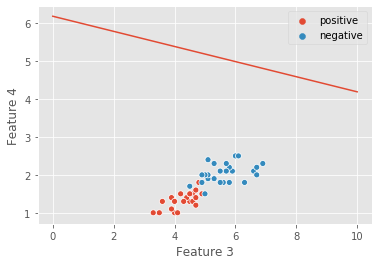

In [6]:
# step 5 plot the feature and hyperplane on plane of feature 1 - feature 2

def get_hyperplane_points(x_start, x_end, weight):
    w_1, w_2 = weight[0, 0], weight[0, 1]
    selected_range = range(x_start, x_end + 1, 1)

    x = np.array(selected_range)
    y = list(map(lambda x: (-(w_1 * x + bias) / w_2).flatten(), selected_range))
    return x, y
        
hyperplane_x, hyperplane_y = get_hyperplane_points(0, 10, weight)

plt.plot(hyperplane_x, hyperplane_y)
sns.scatterplot(x=x_train[:, 0, 0], y=x_train[:, 1, 0], hue=y_train).set(xlabel='Feature 3', ylabel='Feature 4')

In [7]:
# step 6: cross validation

def cross_validation(x_train, x_test, y_train, y_test, c_12=1):
    x_train, x_test = x_test, x_train
    y_train, y_test = y_test, y_train

    weight, bias = get_weight_and_bias_of_hyperplane(x_train, c_12=c_12)
    accuracy, tpr, fpr = predict(x_test, y_test, weight, bias)
    return accuracy, tpr, fpr

accuracy_2, tpr, fpr = cross_validation(x_train, x_test, y_train, y_test)

In [8]:
# step 7: get average accuracy

average_accuracy = (accuracy_1 + accuracy_2) / 2

print("Average of accuracy is {}%".format(average_accuracy))

Average of accuracy is 50.0%


# Part 2 - ROC

the specified parameters of lda: **$C_{21} = 1,\ C_{12} = 1.05^{-1000},\ 1.05^{-999},\ ...,\ 1.05^{999},\ 1.05^{1000}$ **

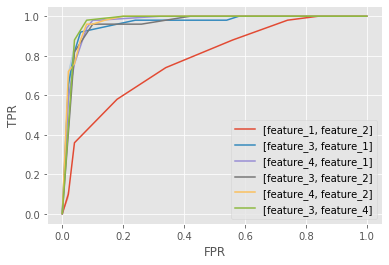

In [9]:
# the function include step 3, 4, 5
def get_accuracy_and_tpr_fpr(x_train, x_test, y_test, c_12):
    # step 3: get TPR and FPR
    weight, bias = get_weight_and_bias_of_hyperplane(x_train, c_12=c_12)

    # step 4: cross validation
    accuracy_1, tpr_1, fpr_1 = predict(x_test, y_test, weight, bias)
    accuracy_2, tpr_2, fpr_2 = cross_validation(x_train, x_test, y_train, y_test, c_12=c_12)

    # step 5: take the averages of tpr and fpr
    average_tpr = (tpr_1 + tpr_2) / 2
    average_fpr = (fpr_1 + fpr_2) / 2
    average_accuracy = (accuracy_1 + accuracy_2) / 2

    return average_accuracy, average_tpr, average_fpr

# step 7: plot six ROC curve on a same plane
roc_curves = []
accuracy_plots = []

# set [positive data, negative data]
feature_crosses = [
    [0, 1],
    [2, 0],
    [3, 0],
    [2, 1],
    [3, 1],
    [2, 3]
]

for feature_cross_index in range(len(feature_crosses)):
    feature_cross = feature_crosses[feature_cross_index]
    feature_1, feature_2 = feature_cross[0], feature_cross[1]

    # step 1 data setting
    positive_data, negative_data = set_positive_and_negative_data(iris_data, [feature_1, feature_2])

    # step 2: split the data in training data and test data
    x_train, x_test, y_train, y_test = get_training_and_test_data(positive_data, negative_data)

    # step 6: plot the ROC curve
    tprs = []
    fprs = []
    accuracys = []
    for index in range(-1000, 1000 + 1, 1):
        c_12 = 1.05 ** index
        
        accuracy, tpr, fpr = get_accuracy_and_tpr_fpr(x_train, x_test, y_test, c_12=c_12)
        accuracys.append(accuracy)
        tprs.append(tpr)
        fprs.append(fpr)

    accuracy_plots.append(accuracys)
    sns.lineplot(x=fprs, y=tprs, label='[feature_{}, feature_{}]'.format(feature_1 + 1, feature_2 + 1)).set(xlabel='FPR', ylabel='TPR')

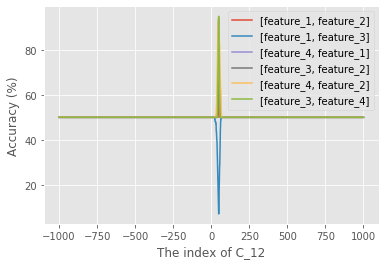

In [77]:
# discussion: What is the relationship between AUC and performance of different feature crosses?

c_12_indices = []
for index in range(-1000, 1000 + 1, 1):
    c_12_indices.append(index)

c_12_indices = np.array(c_12_indices)

for feature_cross_index in range(len(feature_crosses)):
    feature_cross = feature_crosses[feature_cross_index]
    feature_1, feature_2 = feature_cross[0], feature_cross[1]

    sns.lineplot(x=c_12_indices, y=accuracy_plots[feature_cross_index], label='[feature_{}, feature_{}]'.format(feature_1 + 1, feature_2 + 1)).set(xlabel='The index of C_12', ylabel='Accuracy (%)')